# Notebook N04 – Korrelationsanalyse und Zusammenhänge (Trains Only)

**Ziel:** Untersuchung der Abhängigkeiten zwischen Abfahrts- und Ankunftsverspätungen bei Zügen.
**Datengrundlage:** Bereinigter Zug-Datensatz (`istdata_trains_clean.parquet`).
**Methodik:** Einsatz von Polars für Performance und Dichte-Visualisierungen (Hexbin) gegen Overplotting.


In [1]:

import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Plotting-Einstellungen für Publikationsqualität
sns.set_context("talk")
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

print("Setup abgeschlossen. Polars Version:", pl.__version__)

Setup abgeschlossen. Polars Version: 1.35.2


## 1. Daten laden
Wir laden den bereinigten Datensatz, der nur Zugverbindungen enthält.

In [2]:

data_path = Path("../data/processed/istdata_trains_clean.parquet")

# Laden mit Polars
df = pl.read_parquet(data_path)

print(f"Datensatz geladen: {df.height:,} Zeilen und {df.width} Spalten")
print("Spalten:", df.columns)

Datensatz geladen: 4,615,140 Zeilen und 14 Spalten
Spalten: ['BETRIEBSTAG', 'BETREIBER_NAME', 'PRODUKT_ID', 'LINIEN_TEXT', 'HALTESTELLEN_NAME', 'ANKUNFTSZEIT', 'ABFAHRTSZEIT', 'delay_arrival_s', 'delay_departure_s', 'on_time', 'FAELLT_AUS_TF', 'BPUIC', 'Wochentag_Name', 'Ist_Wochenende']


## 2. Feature Engineering & Vorbereitung

Für die Korrelationsanalyse sind Sekunden unhandlich. Wir rechnen in Minuten um.
Zudem betrachten wir für die Korrelation zwischen Abfahrt und Ankunft nur **gefahrene Züge** (`FAELLT_AUS_TF == False`), da ausgefallene Züge keine Ankunftszeit haben (NaN).


In [3]:

# 1. Filter: Nur gefahrene Züge (für Verspätungs-Korrelationen essenziell)
# 2. Berechnung: Minuten statt Sekunden
df_corr = (
    df.filter(pl.col("FAELLT_AUS_TF") == False)
    .with_columns([
        (pl.col("delay_arrival_s") / 60).alias("delay_arrival_min"),
        (pl.col("delay_departure_s") / 60).alias("delay_departure_min")
    ])
    .select([
        "BETREIBER_NAME", 
        "LINIEN_TEXT", 
        "delay_arrival_min", 
        "delay_departure_min",
        "Wochentag_Name" 
    ])
)

print(f"Datensatz für Korrelationsanalyse: {df_corr.height:,} Beobachtungen.")
df_corr.head(5)

Datensatz für Korrelationsanalyse: 4,615,140 Beobachtungen.


BETREIBER_NAME,LINIEN_TEXT,delay_arrival_min,delay_departure_min,Wochentag_Name
str,str,f64,f64,str
"""DB ZugBus Regionalverkehr Alb-…","""IR3""",1.9,1.3,"""Monday"""
"""DB ZugBus Regionalverkehr Alb-…","""RE3""",0.7,0.016667,"""Monday"""
"""DB ZugBus Regionalverkehr Alb-…","""IR3""",0.516667,0.283333,"""Monday"""
"""DB ZugBus Regionalverkehr Alb-…","""RE3""",0.3,-0.033333,"""Monday"""
"""DB ZugBus Regionalverkehr Alb-…","""IR3""",1.383333,0.333333,"""Monday"""


## 3. Statistische Korrelation

Wir berechnen zwei Maße:
1.  **Pearson:** Misst linearen Zusammenhang. Anfällig für extreme Verspätungen.
2.  **Spearman:** Misst den monotonen Zusammenhang (Ränge). Besser geeignet für Verspätungsdaten, die oft nicht normalverteilt sind.


In [4]:

# Polars Berechnung der Korrelation
pearson_corr = df_corr.select(pl.corr("delay_departure_min", "delay_arrival_min", method="pearson")).item()
spearman_corr = df_corr.select(pl.corr("delay_departure_min", "delay_arrival_min", method="spearman")).item()

print(f"Globaler Zusammenhang (Abfahrt vs. Ankunft):")
print(f"Pearson-Korrelation (Linear):  {pearson_corr:.4f}")
print(f"Spearman-Korrelation (Rang):   {spearman_corr:.4f}")

# Interpretation als Markdown ausgeben
if spearman_corr > pearson_corr:
    print("\nHinweis: Spearman > Pearson deutet darauf hin, dass der Zusammenhang zwar stark, aber nicht strikt linear ist (evtl. Ausreißer oder 'Aufhol-Effekte').")

Globaler Zusammenhang (Abfahrt vs. Ankunft):
Pearson-Korrelation (Linear):  0.8197
Spearman-Korrelation (Rang):   0.6837


### 3.1 Die Korrelationsmatrix (Multivariate Analyse)

Wir erweitern die Matrix um die Variable **"Ist Pünktlich"**.
Da dies eine Ja/Nein-Variable ist, wandeln wir sie in 1/0 um.

*Interpretation:*
* **Positive Korrelation zu "Ist Pünktlich":** Faktor begünstigt Pünktlichkeit.
* **Negative Korrelation:** Faktor führt eher zu Verspätungen.

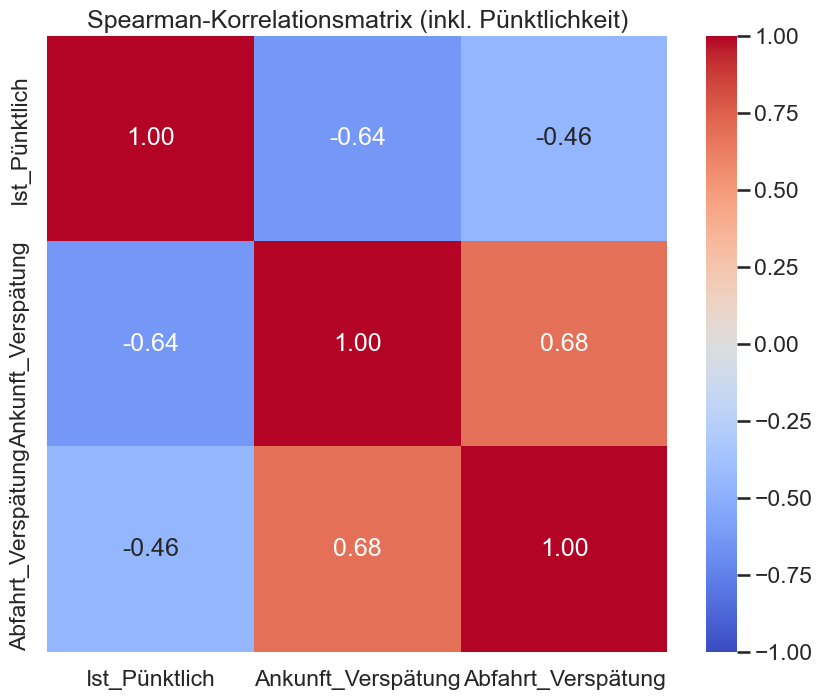

In [5]:

# 1. Daten vorbereiten (Zeit-Features + Pünktlichkeit)
df_matrix = (
    df.filter(pl.col("FAELLT_AUS_TF") == False)
    .with_columns([
        (pl.col("delay_arrival_s") / 60).alias("Ankunft_Verspätung"),
        (pl.col("delay_departure_s") / 60).alias("Abfahrt_Verspätung"),
        # Cast Boolean zu Int (True=1, False=0)
        pl.col("on_time").cast(pl.Int8).alias("Ist_Pünktlich")
    ])
    .select([
        "Ist_Pünktlich",
        "Ankunft_Verspätung",
        "Abfahrt_Verspätung"
    ])
)

# 2. Berechnung der Spearman-Korrelation (Rangkorrelation)
# Wir nutzen wieder den Rank-Trick für Polars
corr_matrix_pl = df_matrix.select(pl.all().rank()).corr()

# 3. Plotting
plt.figure(figsize=(10, 8))
sns.heatmap(
    data=corr_matrix_pl.to_numpy(), 
    annot=True, 
    fmt=".2f", 
    cmap="coolwarm", 
    xticklabels=corr_matrix_pl.columns, 
    yticklabels=corr_matrix_pl.columns,
    vmin=-1, vmax=1
)
plt.title("Spearman-Korrelationsmatrix (inkl. Pünktlichkeit)")
plt.show()

## 4. Visualisierung der Verspätungs-Dynamik

Da wir Millionen von Datenpunkten haben, würde ein normaler Scatterplot nur eine schwarze Wolke zeigen ("Overplotting").

**Lösung:** Ein **Hexbin-Plot** (Jointgrid). Er zeigt, wo sich die meisten Züge befinden.
* **x-Achse:** Abfahrtsverspätung
* **y-Achse:** Ankunftsverspätung
* **Diagonale:** Wenn Punkte *unter* der Diagonalen liegen, hat der Zug Zeit aufgeholt. Liegen sie *darüber*, hat er mehr Verspätung aufgebaut.


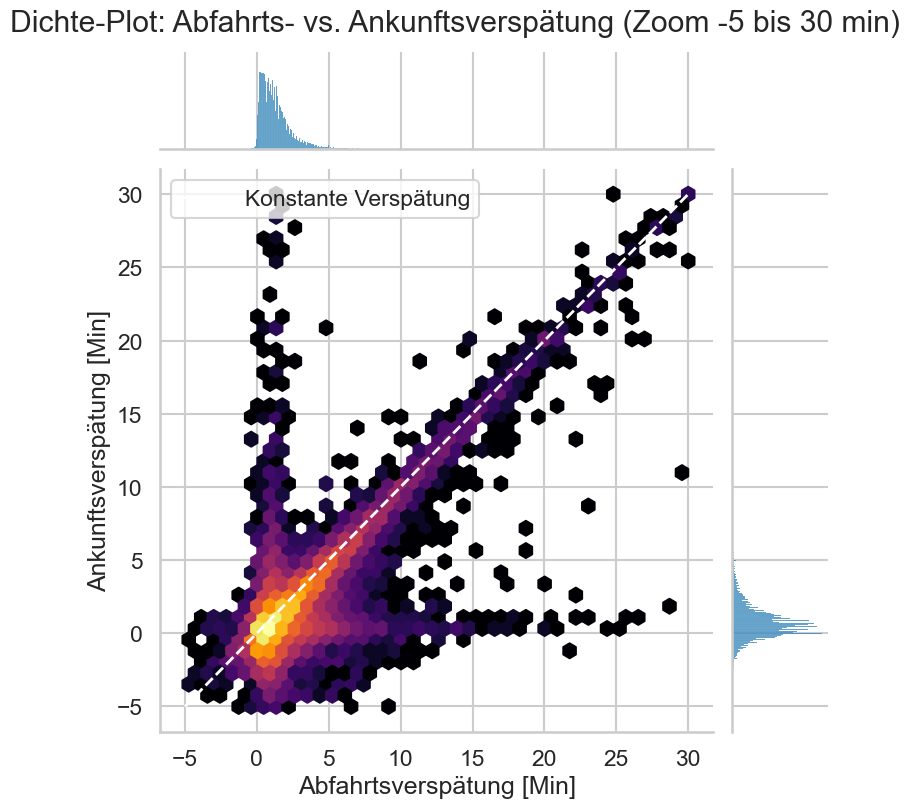

In [6]:

# Sampling für den Plot (200.000 Punkte reichen für eine perfekte Dichte-Darstellung und sparen RAM)
plot_data = df_corr.sample(n=200000, seed=42).to_pandas()

# Filter für den Plot: Wir zoomen auf den relevanten Bereich (-5 bis +30 Minuten)
# um die Masse der Daten zu sehen, nicht die extremen Ausreißer.
plot_data_zoomed = plot_data[
    (plot_data["delay_departure_min"].between(-5, 30)) & 
    (plot_data["delay_arrival_min"].between(-5, 30))
]

g = sns.jointplot(
    data=plot_data_zoomed,
    x="delay_departure_min",
    y="delay_arrival_min",
    kind="hex",          # Hexbin für Dichte
    cmap="inferno",      # Gute Farbskala für Heatmaps
    height=8,
    joint_kws={'gridsize': 40, 'bins': 'log'} # Log-Skala für Farben, um seltene vs. häufige Fälle zu sehen
)

# Diagonale Linie (y=x) einzeichnen
# Alles unter der Linie = Zug hat aufgeholt
g.ax_joint.plot([-5, 30], [-5, 30], 'w--', linewidth=2, label="Konstante Verspätung")

g.fig.suptitle("Dichte-Plot: Abfahrts- vs. Ankunftsverspätung (Zoom -5 bis 30 min)", y=1.02)
g.set_axis_labels("Abfahrtsverspätung [Min]", "Ankunftsverspätung [Min]")
plt.legend(loc='upper left')
plt.show()

## 5. Gruppenspezifische Analyse (Betreiber)

Verhalten sich alle Betreiber gleich? Wir untersuchen die Korrelation getrennt nach den größten Eisenbahnverkehrsunternehmen (EVU).
Dies prüft auf strukturelle Unterschiede (z.B. warten manche Betreiber eher auf Anschlüsse?).

In [7]:

# 1. Die Top 5 Betreiber identifizieren
top_operators = (
    df_corr["BETREIBER_NAME"]
    .value_counts()
    .sort("count", descending=True)
    .head(5)
    ["BETREIBER_NAME"]
    .to_list()
)

print("Analyse für Top 5 Betreiber:", top_operators)

# 2. Korrelationen pro Betreiber berechnen
# Polars GroupBy Context
corr_by_operator = (
    df_corr
    .filter(pl.col("BETREIBER_NAME").is_in(top_operators))
    .group_by("BETREIBER_NAME")
    .agg([
        pl.corr("delay_departure_min", "delay_arrival_min", method="pearson").alias("Pearson_Corr"),
        pl.len().alias("Anzahl_Fahrten")
    ])
    .sort("Pearson_Corr", descending=True)
)

print("\nKorrelation Delay Dep vs. Arr nach Betreiber:")
print(corr_by_operator)

Analyse für Top 5 Betreiber: ['Schweizerische Bundesbahnen SBB', 'BLS AG (bls)', 'THURBO', 'Aargau Verkehr AG', 'Schweizerische Südostbahn (sob)']

Korrelation Delay Dep vs. Arr nach Betreiber:
shape: (5, 3)
┌─────────────────────────────────┬──────────────┬────────────────┐
│ BETREIBER_NAME                  ┆ Pearson_Corr ┆ Anzahl_Fahrten │
│ ---                             ┆ ---          ┆ ---            │
│ str                             ┆ f64          ┆ u32            │
╞═════════════════════════════════╪══════════════╪════════════════╡
│ Aargau Verkehr AG               ┆ 0.863587     ┆ 194534         │
│ BLS AG (bls)                    ┆ 0.793557     ┆ 461639         │
│ Schweizerische Südostbahn (sob… ┆ 0.792929     ┆ 181387         │
│ THURBO                          ┆ 0.782623     ┆ 395503         │
│ Schweizerische Bundesbahnen SB… ┆ 0.756729     ┆ 1901628        │
└─────────────────────────────────┴──────────────┴────────────────┘


### 5.1 Visualisierung der Betreiber-Unterschiede
Wir plotten die Regressionsgeraden für die Top-Betreiber, um zu sehen, wie stark sich Verspätungen "fortpflanzen".

* **Steilere Kurve:** Verspätung bei Abfahrt führt zu *noch mehr* Verspätung bei Ankunft.
* **Flachere Kurve:** Verspätung kann oft aufgeholt werden.


<Figure size 1000x600 with 0 Axes>

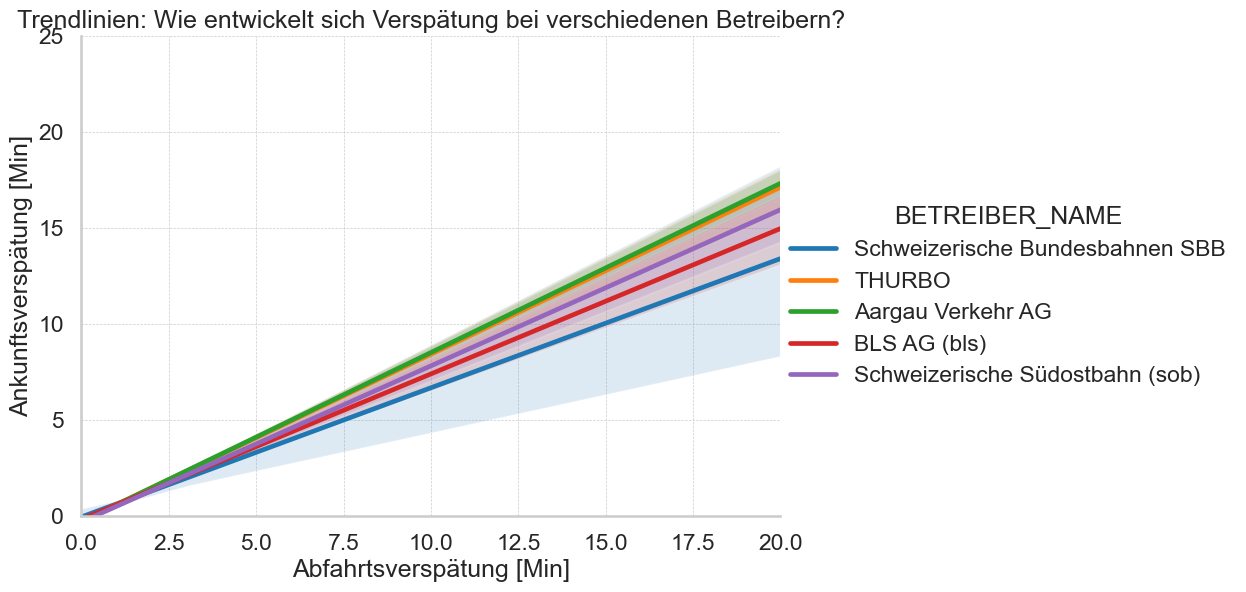

In [8]:

# Daten filtern auf Top Betreiber und Sample ziehen
subset_operators = df_corr.filter(
    pl.col("BETREIBER_NAME").is_in(top_operators)
).sample(n=20000, seed=42).to_pandas()

# Plot
plt.figure(figsize=(10, 6))
sns.lmplot(
    data=subset_operators,
    x="delay_departure_min",
    y="delay_arrival_min",
    hue="BETREIBER_NAME",
    scatter=False,       # Wir lassen die Punkte weg für Klarheit, nur die Trends
    ci=95,               # Konfidenzintervall
    height=6,
    aspect=1.5,
    truncate=False
)

plt.title("Trendlinien: Wie entwickelt sich Verspätung bei verschiedenen Betreibern?")
plt.xlabel("Abfahrtsverspätung [Min]")
plt.ylabel("Ankunftsverspätung [Min]")
plt.xlim(0, 20)  # Fokus auf realistische Verspätungen
plt.ylim(0, 25)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()